In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import copy


In [2]:

# 初期設定
# Setup seeds
#乱数を生成している？
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
import sys
sys.path.append('../semantic_segmentation/')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


../semantic_segmentation/data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
../semantic_segmentation/data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
val_dataset.__getitem__(0)[0].shape: torch.Size([3, 475, 475])
------------------------------------------------
val_dataset.__getitem__(0)[1].shape torch.Size([475, 475])
-------------------------------------------------
val_dataset.__getitem__(0) (tensor([[[ 1.8333,  1.6569,  1.7157,  ...,  1.9314,  1.8333,  1.8725],
         [ 1.7353,  1.5588,  1.6176,  ...,  1.8725,  1.7745,  1.8137],
         [ 1.7157,  1.5392,  1.5784,  ...,  1.8529,  1.7549,  1.7941],
         ...,
         [-0.6176, -0.6373, -0.6961,  ...,  1.3627,  1.3039,  1.3235],
         [-0.7157, -0.6373, -0.6373,  ...,  1.3431,  1.3039,  1.3235],
         [-0.7941, -0.5196, -0.4608,  ...,  1.3431,  1.3039,  1.3235]],

        [[ 1.8333,  1.6569,  1.7157,  ...,  1.9314,  1.8333,  1.8725],
         [ 1.7353,  1.5588,  1.6176,  ...,  1.8725,  1.7745,  1.8137],
         [

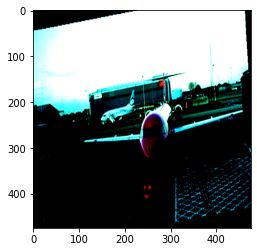

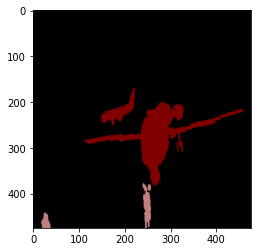

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


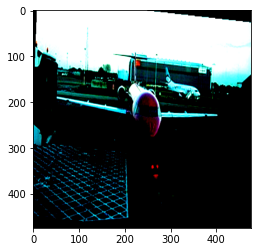

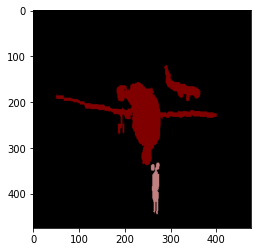

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


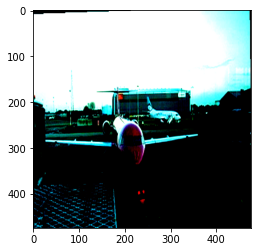

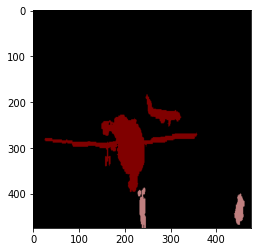

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


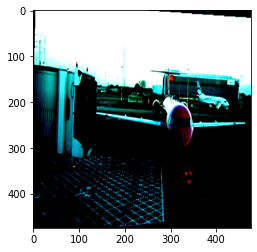

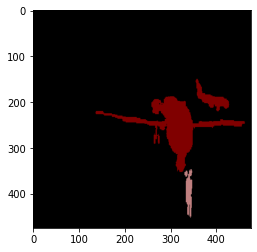

(475, 475, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


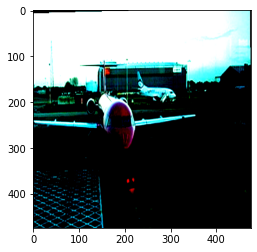

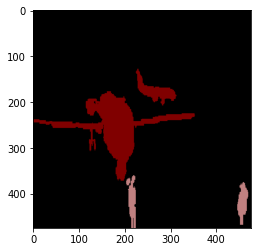

(475, 475, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


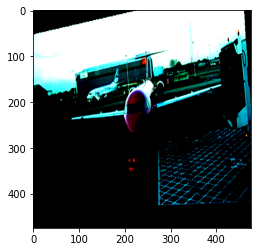

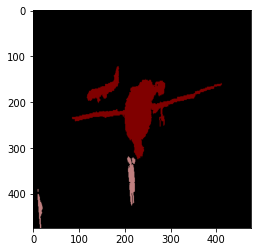

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


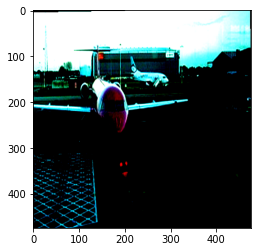

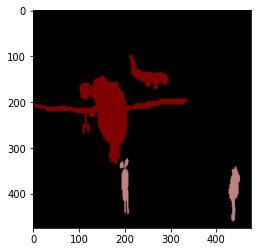

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


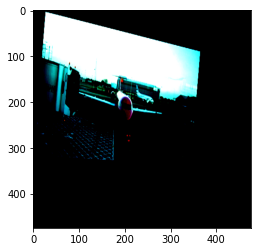

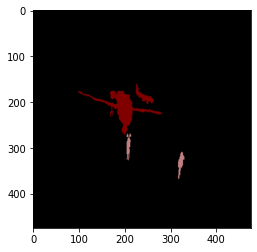

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


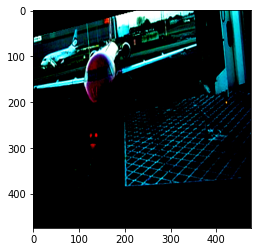

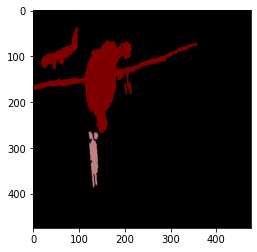

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


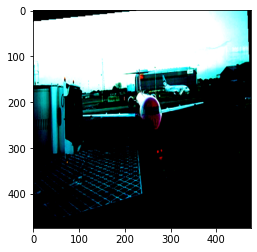

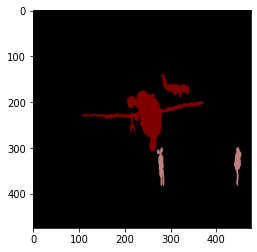

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(475, 475, 3)


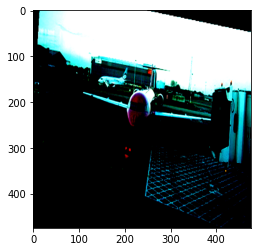

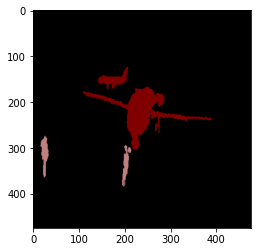

torch.Size([3, 475, 475])


TypeError: Invalid shape (3, 475, 475) for image data

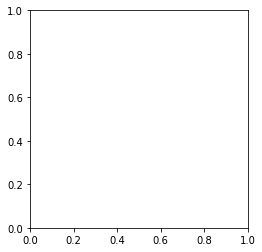

In [4]:
from utils.dataloader_1ch import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
rootpath = "../semantic_segmentation/data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成




# (RGB)の色の平均値と標準偏差
# color_mean = (0.485, 0.456, 0.406) #3ch
# color_std = (0.229, 0.224, 0.225)
color_mean = 0.5 #1ch
color_std = 0.2


train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 2 #8->4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [12]:
image = torch.rand((1,1,475,475))

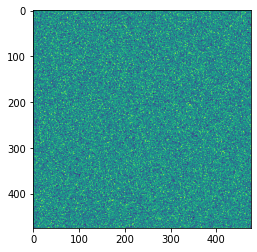

In [13]:
plt.imshow(image.detach().numpy()[0][0])

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = False):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv_1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, bias=False)
        self.conv_2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, bias=False)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        return x
# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(2)
        self.Double_Conv = DoubleConv(in_channels, out_channels)
    def forward(self,x):
        x = self.max_pool(x)
        x = self.Double_Conv(x)
        return x
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear = True):
        super(Up, self).__init__()
        self.up_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2)
        # self.Double_Conv = DoubleConv(out_channels, out_channels)
        
    def forward(self, x):
        x = self.up_trans(x)
        # x = self.Double_Conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self,n_channels,n_classes,input_size,bilinear = True):
        super(UNet,self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.input_size = input_size
        self.Double_Conv_0 = DoubleConv(n_channels,64)
        self.Down_1 = Down(64,128)
        self.Down_2 = Down(128,256)
        self.Down_3 = Down(256,512)
        self.Down_4 = Down(512,1024)
        # self.Up_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        self.Up_1 = Up(1024,512)
        self.Double_Conv_1 = DoubleConv(1024,512)
        
        self.Up_2 = Up(512,256)
        self.Double_Conv_2 = DoubleConv(512,256)
        
        self.Up_3 = Up(256,128)
        self.Double_Conv_3 = DoubleConv(256,128)
        
        self.Up_4 = Up(128,64)
        self.Double_Conv_4 = DoubleConv(128,64)
        
        self.output = nn.Conv2d(64,self.n_classes, kernel_size = 1, bias = False)
        
        
    def crop_image(self, x1, x2):
        delta = x1.size()[2] - x2.size()[2]
        if delta % 2 != 0:
            delta = delta // 2
            x1 = x1[:, :, delta:x1.size()[2] - delta - 1, delta:x1.size()[3] - delta - 1]
        else:
            delta = delta//2
            x1 = x1[:, :, delta:x1.size()[2] - delta, delta:x1.size()[3] - delta]

        return x1
    
    
    def forward(self,x):
        x1 = self.Double_Conv_0(x)
        x2 = self.Down_1(x1)
        x3 = self.Down_2(x2)
        x4 = self.Down_3(x3)
        x5 = self.Down_4(x4)
        x6 = self.Up_1(x5)
        print(x4.size())
        print(x6.size())
        print(self.crop_image(x4,x6).size())
        x7 = torch.cat([x6,self.crop_image(x4,x6)],dim = 1)
        x7 = self.Double_Conv_1(x7)
        
        x7 = self.Up_2(x7)
        x7 = torch.cat([x7,self.crop_image(x3,x7)],dim = 1)
        x7 = self.Double_Conv_2(x7)
        
        x7 = self.Up_3(x7)
        x7 = torch.cat([x7,self.crop_image(x2,x7)],dim = 1)
        x7 = self.Double_Conv_3(x7)
        
        x7 = self.Up_4(x7)
        x7 = torch.cat([x7,self.crop_image(x1,x7)],dim = 1)
        x7 = self.Double_Conv_4(x7)
        
        x7 = F.interpolate(x7,size=(self.input_size,self.input_size), mode="bilinear", align_corners=True )
        output = self.output(x7)

        return output

In [16]:
8/2

4.0

In [17]:
net = UNet(n_channels=1, n_classes = 2, input_size = 475,  bilinear=True)

In [18]:
net(image).size()

torch.Size([1, 512, 51, 51])
torch.Size([1, 512, 42, 42])
torch.Size([1, 512, 42, 42])


torch.Size([1, 2, 475, 475])

In [19]:
from utils.UNet import UNet

In [20]:
arr = np.load("/home/filament/Downloads/semantic_segmentation/data/VOCdevkit/VOC2012/filament_taurus_datasets_grey_arcnorm_array/taurus_1.npy")

In [21]:
tensor = torch.from_numpy(arr)
tensor = tensor.unsqueeze(0).unsqueeze(0)
tensor.size()

torch.Size([1, 1, 475, 475])

In [22]:
net = UNet(n_channels = 1, n_classes = 2,input_size = tensor.size()[2] ,bilinear = False)

In [23]:
net(tensor).size()

torch.Size([1, 2, 475, 475])